In [1]:
import os
import random
import ipywidgets as widgets
from datetime import datetime
from traitlets import TraitError
from copy import deepcopy
from threading import Event

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split
from torchinfo import summary

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#MLOps
import mlflow
mlflow.enable_system_metrics_logging()

#gRPC
import sys
sys.path.append('./gRPC') # Append gRPC modules
import gRPC.grpc_client as grpc_client
import gRPC.grpc_server as grpc_server

from concurrent import futures

import grpc
import spikes_pb2 as pb2
import spikes_pb2_grpc as pb2_grpc

from dvs_camera_sim import CameraSimulation


%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(25,15)})

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

# General settings
base_path = 'E:/LTU/X7013E/'


In [2]:
# UI
l_section = widgets.Layout(border='solid 1px', padding='5px', height = '200px')
l_inner_section = widgets.Layout(margin='100px')

s_header = dict(font_weight='bold')
s_small_description = dict(description_width='50%')

stop_flag = 0


Each row corresponds to a single event, which consists of four parameters: (x-coordinate, y-coordinate, timestamp, polarity).

In [3]:
class NetworkSimulationLayer(nn.modules.Module):
    def __init__(self, delay_mean=0, delay_std=0, noise=0, frame_mean=0, frame_std=0, frame_noise=0) -> None:
        super().__init__()
        assert 0 <= noise <= 1, "The value for spike_loss needs to be between 0 and 1"
        self.noise = noise # Fraction of spikes from event vector removed (0.0 - 1.0)
        self.mean = delay_mean # Average spikes delay (given as frames)
        self.std = delay_std # Standard devitation of spikes delay (given as frames)
        
        self.frame_noise = frame_noise # Fraction of frames removed (0.0 - 1.0)
        self.frame_mean = delay_mean # Average spikes delay (given as frames)
        self.frame_std = delay_std # Standard devitation of spikes delay (given as frames)
        
        self.delayed_spikes = {}
        
    def forward(self, events: torch.Tensor, step) -> torch.Tensor:
        if step == 0:
            self.reset()            
        #events = self.add_noise(events)
        
        events = self.frame_remove(events)
        #events = self.frame_delay(events)
        events = self.remove(events)
        events = self.add_delay(events)
        
        return events
    
    def frame_remove(self, events):
        if torch.rand(1) < self.frame_noise:
            events.zero_()
            
        return events
    
    def frame_delay(self, events):
        # Create a random delay based on normal distribution for all frames
        delay_mask = events * torch.normal(mean=self.mean, std=self.std, size=events.shape).int().to(device)

        events[delay_mask > 0] = 0 # Remove all delayed events from vector
        if 1 in self.delayed_spikes: # Add delays from previous steps
            events[self.delayed_spikes.pop(1)] = 1
            self.delayed_spikes = {key - 1: value for key, value in self.delayed_spikes.items()}

        for idx in torch.unique(delay_mask):
            if idx < 1: # Ignore all delays that are 0 or less (=no delay)
                continue
            if idx in self.delayed_spikes:
                self.delayed_spikes[idx.item()] += delay_mask # Bool tensor
            else:
                self.delayed_spikes[idx.item()] = (delay_mask == idx)
        
        return events
    
    def remove(self, events):
        # Get all events and add noise to decide delay
        spike_indices = torch.nonzero(events)
        noise_vec = torch.rand(len(spike_indices)) # Uniform distribution
        spikes_to_remove = spike_indices[noise_vec < self.noise]

        # Set removed spikes to zero
        events[torch.unbind(spikes_to_remove, dim=1)] = 0
        
        return events
    
    def add_noise(self, events):
        # Decide where to add noise
        noise_vec = torch.rand(events.shape).float() < self.noise
        # Define a random spike tensor
        random_events = torch.randint(0, 2, size=events.shape).float().to(device)
        # Overwrite with random events
        events[noise_vec] = random_events[noise_vec]
        
        return events

    def add_delay(self, events):
        # Create a random delay based on normal distribution for all events
        delay_mask = events * torch.normal(mean=self.mean, std=self.std, size=events.shape).int().to(device)

        events[delay_mask > 0] = 0 # Remove all delayed events from vector
        if 1 in self.delayed_spikes: # Add delays from previous steps
            events[self.delayed_spikes.pop(1)] = 1
            self.delayed_spikes = {key - 1: value for key, value in self.delayed_spikes.items()}

        for idx in torch.unique(delay_mask):
            if idx < 1: # Ignore all delays that are 0 or less (=no delay)
                continue
            if idx in self.delayed_spikes:
                self.delayed_spikes[idx.item()] += delay_mask # Bool tensor
            else:
                self.delayed_spikes[idx.item()] = (delay_mask == idx)
        
        return events

    def reset(self):
        # Clear delayed spikes
        self.delayed_spikes = {}


In [5]:
class StepSequential(nn.Sequential):
    def forward(self, x, step):        
        for module in self:
            if isinstance(module, StepSequential):
                x = module(x, step)
            elif isinstance(module, nn.ModuleList):
                x = module[step](x)
            elif isinstance(module, snn.Leaky):
                if step == 0:
                    self.mem = module.init_leaky()
                x, self.mem = module(x, self.mem)
            else:
                x = module(x)
        return x


class ClassifierRate(nn.Module):
    def __init__(self, beta, spike_grad, thresh, input_size, output_size):
        super().__init__()    
        self.input_size = input_size    
        self.output_size = output_size
        self.beta = beta
        self.spike_grad = spike_grad
        self.thresh = thresh
        
        # Adapt to different input frame size
        fc1_size = int(64 * input_size[0] / 4 * input_size[1] / 4)
        
        # Convolution layers
        self.layers = StepSequential(
            StepSequential(
                nn.Conv2d(2, 32, 3, padding=1, stride=2),
                nn.BatchNorm2d(32),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Conv2d(32, 64, 3, padding=1, stride=2),
                nn.BatchNorm2d(64),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Flatten(start_dim = 1, end_dim = 3),
                nn.Linear(fc1_size, 512),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Linear(512, self.output_size),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh)
            ),
        )
               
    def forward(self, x, step):
        x = self.layers(x, step)
        
        return x


class ClassifierTTFS(nn.Module):
    def __init__(self, beta, spike_grad, thresh, input_size, output_size):
        super().__init__()    
        self.input_size = input_size    
        self.output_size = output_size
        self.beta = beta
        self.spike_grad = spike_grad
        self.thresh = thresh
        
        # Adapt to different input frame size
        fc1_size = int(64 * input_size[0] / 4 * input_size[1] / 4)
        
        # Convolution layers
        self.layers = StepSequential(
            StepSequential(
                nn.Conv2d(2, 32, 3, padding=1, stride=2),
                nn.BatchNorm2d(32),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Conv2d(32, 64, 3, padding=1, stride=2),
                nn.BatchNorm2d(64),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Flatten(start_dim = 1, end_dim = 3),
                nn.Linear(fc1_size, 512),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Linear(512, self.output_size),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh)
            ),
        )
               
    def forward(self, x, step):
        x = self.layers(x, step)
        
        return x
    
    def classify(self, events):
        with torch.no_grad():
            events = events.unsqueeze(dim=0).to(device)
            
            # Forward pass
            frames, spk, mem = self(events)
            
            # Find the index of the spiking neuron
            if spk.sum() == 0:
                prediction = "No prediction made"
            elif spk.sum() > 1:
                prediction = "Several predictions made"
            else:
                prediction = int(torch.argmax(spk, dim=1))
            return prediction, int(frames)


class ClassifierNofM(nn.Module):
    def __init__(self, n, beta, spike_grad, thresh, input_size, output_size, n_time_steps):
        super().__init__()    
        self.input_size = input_size    
        self.output_size = output_size
        self.n_time_steps = n_time_steps
        self.beta = beta
        self.spike_grad = spike_grad
        self.thresh = thresh
        
        # Adapt to different input frame size
        fc1_size = int(64 * input_size[0] / 4 * input_size[1] / 4)
        
        self.n = n
        self.class_connections = {
            0: [0, 1, 2, 3],
            1: [4, 5, 6, 7],
            2: [1, 3, 5, 9],
            3: [0, 2, 6, 8],
            4: [1, 4, 7, 9],
            5: [0, 3, 5, 8],
            6: [2, 4, 6, 9],
            7: [0, 2, 7, 8],
            8: [1, 3, 6, 8],
            9: [0, 4, 5, 7],
            10: [0, 1, 8, 9]
        }
        
        # Convolution layers
        self.layers = StepSequential(
            StepSequential(
                nn.Conv2d(2, 32, 3, padding=1, stride=2),
                nn.ModuleList([nn.BatchNorm2d(32) for i in range(self.n_time_steps)]),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Conv2d(32, 64, 3, padding=1, stride=2),
                nn.ModuleList([nn.BatchNorm2d(64) for i in range(self.n_time_steps)]),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Flatten(start_dim = 1, end_dim = 3),
                nn.Linear(fc1_size, 512),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh),
            ),
            StepSequential(
                nn.Linear(512, self.output_size),
                snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False, threshold=thresh)
            ),
        )
               
    def forward(self, x, step):
        x = self.layers(x, step)
        
        return x    


In [8]:
# DATASET SETUP
class DatasetModule:
    def __init__(self, dataset_name="nmnist", train_split=0.8, noise_mean=0, noise_std=0, bin_type="time", bin_time_window=1000):
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        
        # Tags
        self.dataset_name = dataset_name
        self.bin_type = bin_type
        self.sensor_size = None
        self.outputs = None
        
        # Params
        self.batch_size = None
        self.frame_size = None
        self.n_time_bins = None
        self.bin_time_window = bin_time_window
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.train_split = train_split
        self.transform_list = None
        
        self.update_tags_params()
    
    def update_tags_params(self):
        # Logging
        self.tags = {
            "dataset_name": self.dataset_name,
            "dataset_input_size": self.sensor_size,
            "dataset_output_size": self.outputs,
            }
        
        self.params = {
            "dataset_batch_size": self.batch_size,
            "dataset_frame_size": self.frame_size,
            "dataset_noise_mean": self.noise_mean,
            "dataset_noise_std": self.noise_std,
            "dataset_train_split": self.train_split,
            "dataset_transform": self.transform_list,
            "dataset_bin_type": self.bin_type,
        }
        
        # Conditional tags and params
        if self.bin_type == "bins":
            self.params.update(
                {"dataset_n_time_bins": self.n_time_bins}
            )
        elif self.bin_type == "time":
            self.params.update(
                {"dataset_bin_time_window_us": self.bin_time_window}
            )
        
    def prepare(self):
        # Set up dataset specific parameters
        if self.dataset_name == "nmnist":
            self.batch_size = 128
            self.sensor_size = tonic.datasets.NMNIST.sensor_size
            self.outputs = len(tonic.datasets.NMNIST.classes)
            self.frame_size = (32, 32, 2)
            train_dataset = tonic.datasets.NMNIST(save_to=f'{base_path}/data/nmnist', train=True)
            test_dataset = tonic.datasets.NMNIST(save_to=f'{base_path}/data/nmnist', train=False)
            if self.bin_type == "bins":
                self.n_time_bins = 32
                self.transform_list = [
                    transforms.CenterCrop(sensor_size=self.sensor_size, size=self.frame_size),
                    transforms.ToFrame(sensor_size=self.frame_size, n_time_bins=self.n_time_bins) #time_window=10000), # us to 1 ms
                    ]
            elif self.bin_type == "time":
                self.transform_list = [
                    transforms.CenterCrop(sensor_size=self.sensor_size, size=self.frame_size),
                    transforms.ToFrame(sensor_size=self.frame_size, time_window=self.bin_time_window) #time_window=10000), # us to 1 ms
                    ]
        elif self.dataset_name == "dvsgesture":
            self.batch_size = 16
            self.sensor_size = tonic.datasets.DVSGesture.sensor_size
            self.outputs = len(tonic.datasets.DVSGesture.classes)
            self.frame_size = self.sensor_size
            train_dataset = tonic.datasets.DVSGesture(save_to=f'{base_path}/data/dvsgesture', train=True)
            test_dataset = tonic.datasets.DVSGesture(save_to=f'{base_path}/data/dvsgesture', train=False)
            if self.bin_type == "bins":
                self.n_time_bins = 320
                self.transform_list = [
                    transforms.ToFrame(sensor_size=self.frame_size, n_time_bins=self.n_time_bins) #time_window=10000), # us to 1 ms
                    ]
            elif self.bin_type == "time":
                self.transform_list = [
                    transforms.ToFrame(sensor_size=self.frame_size, time_window=self.bin_time_window) #time_window=10000), # us to 1 ms
                    ]
        else:
            print("Invalid dataset name")
        
        # Add gaussian noise
        if self.noise_mean != 0 or self.noise_std != 0:
            self.transform_list.append(AddGaussianNoiseTime(mean=self.noise_mean, std=self.noise_std))
            dataset_path = f"{self.dataset_name}_noise_mean_{self.noise_mean}_std{self.noise_std}"
        else:
            dataset_path = self.dataset_name
            
        transform = transforms.Compose(self.transform_list)

        train_dataset, val_dataset = self.split_train_val(dataset=train_dataset)
        
        # Cache datasets
        cached_trainset = DiskCachedDataset(train_dataset, cache_path=f'{base_path}/classifier/cache/{dataset_path}/train', transform=transform)
        cached_valset = DiskCachedDataset(val_dataset, cache_path=f'{base_path}/classifier/cache/{dataset_path}/val', transform=transform)
        cached_testset = DiskCachedDataset(test_dataset, cache_path=f'{base_path}/classifier/cache/{dataset_path}/test', transform=transform)

        # Create dataloaders
        self.train_loader = DataLoader(cached_trainset, batch_size=self.batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
        self.val_loader = DataLoader(cached_valset, batch_size=self.batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=False)
        self.test_loader = DataLoader(cached_testset, batch_size=self.batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
        
        self.update_tags_params()

    # Split dataset into training and validation sets
    def split_train_val(self, dataset):
        train_size = int(self.train_split * len(dataset))  # 80% training, 20% validation
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        return train_dataset, val_dataset
    
    def generate_ui(self):
        # Widgets
        self.w_label = widgets.Label(value='Dataset:', style=s_header)
        self.w_name = widgets.ToggleButtons(options=[("NMNIST", "nmnist"), ("DVS Gesture", "dvsgesture")])
        self.w_train_split = widgets.FloatText(value = self.train_split, description = 'Train split', step = 0.05)
        
        self.w_bin_label = widgets.Label(value='Bin type:', style=s_header)
        self.w_bin_type = widgets.ToggleButtons(options=[("Bins", "bins"), ("Time", "time")])
        self.w_time_window = widgets.IntText(value=self.bin_time_window, description='Time window', step = 100)
        
        self.w_bin_type_stack = widgets.Stack([widgets.Box([]), self.w_time_window], selected_index=0)
        widgets.jslink((self.w_bin_type, 'index'), (self.w_bin_type_stack, 'selected_index'))
        
        self.w_section =  widgets.HBox([
            widgets.VBox([
                self.w_label,
                self.w_name,
                self.w_train_split,
            ]),
            widgets.VBox([
                self.w_bin_label,
                self.w_bin_type,
                self.w_bin_type_stack
            ])
            ], layout=l_section)

        # Observer methods
        self.w_name.observe(self._on_name_change, names='value')
        self.w_train_split.observe(self._on_train_split_change, names='value')
        self.w_bin_type.observe(self._on_bin_type_change, names='value')
        self.w_time_window.observe(self._on_time_window_change, names='value')
        
        return self.w_section
    
    def update_ui_values(self, load_dict: dict):
        self.w_name.value = load_dict.get("tags.dataset_name") or self.tags["dataset_name"]
        self.w_train_split.value = load_dict.get("params.dataset_train_split") or self.params["dataset_train_split"]
        self.w_bin_type = load_dict.get("params.dataset_bin_type") or self.params["dataset_bin_type"]
        self.w_time_window = load_dict.get("params.dataset_bin_time_window_us") or self.params["dataset_bin_time_window_us"]

    def _on_name_change(self, change):
        self.dataset_name = change['new']
        
    def _on_train_split_change(self, change):
        self.train_split = change['new']
        
    def _on_bin_type_change(self, change):
        self.bin_type = change['new']
    
    def _on_time_window_change(self, change):
        self.bin_time_window = change['new']
    

# Class to introduce gaussian noise on initial AER time
class AddGaussianNoiseTime(object):
    def __init__(self, mean=0.0, std=5.0):
        self.std = std
        self.mean = mean
        
    def __call__(self, events):
        noise = np.random.normal(size=len(events)) * self.std + self.mean
        events["t"] = events["t"] + noise
        return events
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [9]:
# MODEL SETUP
class ModelModule():
    def __init__(self, model_name="ttfs", lif_beta=0.5, lif_spike_grad_name="fast_sigmoid", lif_thresh=1):
        self.model = None
        self.model_split = None
        
        # Tags
        self._model_name = model_name
        
        # Params
        self.n = 4
        self.lif_beta = lif_beta
        self.lif_spike_grad_name = lif_spike_grad_name
        self.lif_spike_grad = None
        self.lif_thresh = lif_thresh
        self.lif_fast_sigmoid_slope = 25
        self.lif_atan_alpha = 2
        
        self.update_tags_params()
    
    @property    
    def model_name(self):
        return self._model_name
    
    @model_name.setter
    def model_name(self, value):
        self._model_name = value
    
    def update_tags_params(self):
        self.tags = {
            "model_name": self._model_name,
        }

        self.params = {
            "model_lif_beta": self.lif_beta,
            "model_lif_spike_gradient_function": self.lif_spike_grad_name,
            "model_lif_threshold": self.lif_thresh,
        }
        
        # Conditional tags and params
        if self._model_name == "nom":
            self.params.update(
                {"model_n": self.n}
            )
        
        if self.lif_spike_grad_name == "fast_sigmoid":
            self.params.update(
                {"model_lif_fast_sigmoid_slope": self.lif_fast_sigmoid_slope}
            )
        elif self.lif_spike_grad_name == "atan":
            self.params.update(
                {"model_lif_atan_alpha": self.lif_atan_alpha}
            )
    
    def prepare(self, dataset_module, tracker_module):
        self.dataset_module = dataset_module
        self.tracker_module = tracker_module
        
        self.lif_spike_grad = self.instantiate_spike_grad()
        self.model = self.instantiate_model()
        
        self.update_tags_params()
        
    def instantiate_spike_grad(self):
        if self.lif_spike_grad_name == "fast_sigmoid":
            lif_spike_grad = surrogate.fast_sigmoid(slope=self.lif_fast_sigmoid_slope)
        elif self.lif_spike_grad_name == "atan":
            lif_spike_grad = surrogate.atan(alpha=self.lif_atan_alpha)
        else:
            print("Invalid spike gradient")
        return lif_spike_grad
    
    def instantiate_model(self):    
        # See if there is a mlflow loaded model
        loaded_model = self.tracker_module.loaded_model
        if loaded_model:
            return loaded_model
        else:
            input_size = self.dataset_module.params["dataset_frame_size"]
            output_size = self.dataset_module.tags["dataset_output_size"]
            #n_time_steps = self.dataset_module.params["dataset_n_time_bins"]
            
            if self._model_name == "rate":
                model = ClassifierRate(
                        beta=self.lif_beta,
                        spike_grad=self.lif_spike_grad,
                        thresh=self.lif_thresh,
                        input_size=input_size,
                        output_size=output_size,).to(device)
            elif self._model_name == "ttfs":
                model = ClassifierTTFS(
                        beta=self.lif_beta,
                        spike_grad=self.lif_spike_grad,
                        thresh=self.lif_thresh,
                        input_size=input_size,
                        output_size=output_size,).to(device)
            elif self._model_name == "nom":
                model = ClassifierNofM(
                    n=self.n,
                    beta=self.lif_beta,
                    spike_grad=self.lif_spike_grad,
                    thresh=self.lif_thresh,
                    input_size=input_size,
                    output_size=output_size,).to(device)
            else:
                print("Invalid model name")
            
            return model

    def split_model(self, split_index):
        self.model_split1 = self.instantiate_model()
        self.model_split1.load_state_dict(self.model.state_dict())
        self.model_split1.layers = self.model.layers[:split_index]
        
        self.model_split2 = self.instantiate_model()
        self.model_split2.load_state_dict(self.model.state_dict())
        self.model_split2.layers = self.model.layers[split_index:]
        
        #self.model_split = [self.model_split1, self.model_split2]
    
    def generate_ui(self):
        self.w_label = widgets.Label(value='Model:', style=s_header)
        self.w_name = widgets.ToggleButtons(options=[('Rate', "rate"), ('Time-to-first-spike', "ttfs"), ('N of M', "nom")], value=self._model_name)
        self.w_n = widgets.IntText(value=self.n, description='N', step = 1, disabled=True)
        
        self.w_name_stack = widgets.Stack([widgets.Box([]), widgets.Box([]), self.w_n], selected_index=0)
        widgets.jslink((self.w_name, 'index'), (self.w_name_stack, 'selected_index'))
        
        self.w_lif_label = widgets.Label(value='LIF Neuron:', style=s_header)
        self.w_lif_spike_grad = widgets.ToggleButtons(
            options = [("Fast sigmoid", "fast_sigmoid"), ('ATan', "atan")],
            value = self.lif_spike_grad_name,
        )
        self.w_lif_beta = widgets.FloatText(value=self.lif_beta, description='Beta', step = 0.05)
        self.w_lif_threshold = widgets.FloatText(value=self.lif_thresh, description='Threshold', step = 0.5)
        
        self.w_section = widgets.HBox([
            widgets.VBox([
                self.w_label,
                widgets.VBox([
                    self.w_name,
                    self.w_name_stack,
                ]),
            ]),
            widgets.VBox([
                self.w_lif_label,
                widgets.VBox([
                    self.w_lif_spike_grad,
                    self.w_lif_beta,
                    self.w_lif_threshold,
                ])
            ])
        ], layout=l_section)
        
        # Observer methods
        self.w_name.observe(self._on_name_change, names='value')
        self.w_lif_spike_grad.observe(self._on_lif_spike_grad_change, names='value')
        self.w_lif_beta.observe(self._on_lif_beta_change, names='value')
        self.w_lif_threshold.observe(self._on_lif_thresh_change, names='value')
        
        return self.w_section
    
    def update_ui_values(self, load_dict: dict):
        self.w_name.value = load_dict.get("tags.model_name") or self._model_name
        self.w_lif_spike_grad.value = load_dict.get("params.model_lif_spike_grad") or self.lif_spike_grad_name
        self.w_lif_beta.value = load_dict.get("params.model_lif_beta") or self.lif_beta
        self.w_lif_threshold.value = load_dict.get("params.model_lif_threshold") or self.lif_thresh
    
    def _on_name_change(self, change):
        self._model_name = change['new']
        
    def _on_lif_spike_grad_change(self, change):
        self.lif_spike_grad_name = change['new']
        
    def _on_lif_beta_change(self, change):
        self.lif_beta = change['new']
        
    def _on_lif_thresh_change(self, change):
        self.lif_threshold = change['new']


In [11]:
class SpikeTransferService(pb2_grpc.SpikeTransferServicer):
    
    def __init__(self, *args, **kwargs):
        self.val_iter = iter(dataset_module.val_loader)
    
    def GetServerName(self, request, context):
        # get the string from the incoming request
        name = request.client_name
        return pb2.ServerNameResponse(server_name=f"Hello, {name}! This is the gRPC server talking!")
    
    def GetEventDataStream(self, request, context):
        for key, value in context.invocation_metadata():
            print("Received initial metadata: key=%s value=%s" % (key, value))
            
        try:
            data, label = next(self.val_iter)
        except StopIteration:
            # StopIteration raised when the iterator is exhausted
            return
        
        shape = data[0].shape
        data = data[0].flatten(start_dim=1, end_dim=3)
        label = label[0].item()
        #print(label)
        
        yield pb2.EventData(label=label)
        
        for step, frame in enumerate(data):
            yield pb2.EventData(shape=shape[1:], data=frame)


In [12]:
# NETWORK SETUP
class NetworkModule():
    def __init__(self, net_layer_pos=0, grpc_port=50051, sim_delay_mean=0, sim_delay_std=0, sim_noise=0, sim_frame_delay_mean=0, sim_frame_delay_std=0, sim_frame_noise=0):
        self.available_net_pos = 0
        
        # Tags
        self.network_type = "none"
        
        # Params
        self.net_layer_pos = net_layer_pos
        
        self.sim_delay_mean = sim_delay_mean
        self.sim_delay_std = sim_delay_std
        self.sim_noise = sim_noise
        self.sim_frame_delay_mean = sim_frame_delay_mean
        self.sim_frame_delay_std = sim_frame_delay_std
        self.sim_frame_noise = sim_frame_noise
        
        self.grpc_port = grpc_port
        
        self.update_tags_params()
    
    def update_tags_params(self):        
        self.tags = {
            "network_type": self.network_type,
        }
        
        self.params = {}

        if self.network_type == "sim":
            self.params.update({
                "network_layer_pos": self.net_layer_pos,
                "network_sim_spike_delay_mean": self.sim_delay_mean,
                "network_sim_spike_delay_std": self.sim_delay_std,
                "network_sim_spike_noise": self.sim_noise,
                "network_sim_frame_delay_mean": self.sim_frame_delay_mean,
                "network_sim_frame_delay_std": self.sim_frame_delay_std,
                "network_sim_frame_noise": self.sim_frame_noise,
            })
        elif self.network_type == "grpc":
            self.params.update({})
    
    def prepare(self, model_module: ModelModule):
        self.model_module = model_module
        #self.w_model_layers.append_stdout(str(self.model_module.model.layers))
        if self.model_module.model.layers:
            self.available_net_pos = len(self.model_module.model.layers)
        else:
            self.available_net_pos = 0
        self.w_net_layer_pos.max = self.available_net_pos
        
    def on_run(self):
        if self.network_type == "sim":
            self.model_module.split_model(self.net_layer_pos)
            
            self.net_sim_layer = NetworkSimulationLayer(
                delay_mean=self.sim_delay_mean,
                delay_std=self.sim_delay_std,
                noise=self.sim_noise,
                frame_mean=self.sim_frame_delay_mean,
                frame_std=self.sim_frame_delay_std,
                frame_noise=self.sim_frame_noise,
                )

        self.update_tags_params()
    
    def get_server_name(self):
        with grpc.insecure_channel(f'localhost:{self.grpc_port}') as channel:
            stub = pb2_grpc.SpikeTransferStub(channel)
            request_msg = pb2.ServerNameRequest(client_name='you')
            response_msg = stub.GetServerName(request_msg)
            print("Client received: " + response_msg.server_name)
        
    def get_data_stream(self):
        all_frames = []
        with grpc.insecure_channel(f'localhost:{self.grpc_port}') as channel:
            stub = pb2_grpc.SpikeTransferStub(channel)
            request_msg = pb2.EventDataRequest()

            response_stream = stub.GetEventDataStream(request_msg)
            for idx, response in enumerate(response_stream):
                print("Data", response.data)
                print("Shape", response.shape)
                print("Label", response.label)
                #print("Label", response.label)
                #print(response.label)
                if idx == 0:
                    print(idx)
                    # The first response contains metadata (label)
                    #label = response.label
                else:
                    # Process each frame response
                    shape = list(response.shape)
                    data = list(response.data)
                    
                    # Create the tensor
                    frame = torch.tensor(data).reshape(shape)
                    all_frames.append(frame)
            
            frames = torch.stack(all_frames, dim=0)
            #labels = torch.tensor(labels)
            
            #print(label)
                
            #return frames, labels
    
    def grpc_test_connection(self):
        # if self.tags["network_type"] != "grpc":
        #     return
        grpc_client.get_server_name(str(self.grpc_port))
        #response_tensor = net_client.get_frame(port)
        #return response_tensor
        
    def grpc_host_server(self):
        print(f"Server started at port {self.grpc_port}")
        self.server = grpc_server.serve(str(self.grpc_port))
        
    def serve(self):
        self.server = grpc.server(futures.ThreadPoolExecutor(max_workers=10))
        pb2_grpc.add_SpikeTransferServicer_to_server(SpikeTransferService(), self.server)
        self.server.add_insecure_port(f"[::]:{self.grpc_port}")
        self.server.start()
        print(f"gRPC server started, listening on {self.grpc_port}")
        self.server.wait_for_termination()
        
    def grpc_stop_server(self):
        print(f"Server stopped at port {self.grpc_port}")
        self.server.stop()
    
    def generate_ui(self):
        self.w_label = widgets.Label(value='Network:', style=s_header)
        self.w_type = widgets.ToggleButtons(
            options = [('None', "none"), ('Simulation', "sim"), ('gRPC', "grpc")],
            tooltips = ['Local model', 'Simulate a network layer in the model', 'Connect to server'],
        )
        self.w_model_layers = widgets.Output()
        self.w_net_layer_pos = widgets.IntSlider(
            value=self.net_layer_pos, min=0, max=0, step=1,
            description="Net sim layer",
            orientation='horizontal',
            readout=True,
            readout_format='d' 
        )
        self.w_sim_delay_mean = widgets.FloatText(value = self.sim_delay_mean, description = 'Mean spike delay', step = 0.5, style=s_small_description)
        self.w_sim_delay_std = widgets.FloatText(value = self.sim_delay_std, description = 'STD spike delay', step = 0.5, style=s_small_description)
        self.w_sim_noise = widgets.FloatText(value = self.sim_noise, description = 'Spike loss', step = 0.05, style=s_small_description)
        self.w_sim_frame_delay_mean = widgets.FloatText(value = self.sim_frame_delay_mean, description = 'Mean bin delay', step = 0.5, style=s_small_description)
        self.w_sim_frame_delay_std = widgets.FloatText(value = self.sim_frame_delay_std, description = 'STD bin delay', step = 0.5, style=s_small_description)
        self.w_sim_frame_noise = widgets.FloatText(value = self.sim_frame_noise, description = 'Bin loss', step = 0.05, style=s_small_description)
        self.w_grpc_port = widgets.IntText(value = self.grpc_port, description = 'Port', step = 1)
        self.w_grpc_host_server_button = widgets.Button(description='Host Server')
        self.w_grpc_stop_server_button = widgets.Button(description='Stop Server')
        self.w_grpc_test_connection_button = widgets.Button(description='Test Connection')
        self.w_grpc_connect_button = widgets.Button(description='Connect')
        
        self.w_none_section = widgets.Box([])
        self.w_sim_section = widgets.VBox([
            self.w_net_layer_pos,
            widgets.HBox([
                widgets.VBox([
                    self.w_sim_delay_mean,
                    self.w_sim_delay_std,
                    self.w_sim_noise,
                ]),
                widgets.VBox([
                    self.w_sim_frame_delay_mean,
                    self.w_sim_frame_delay_std,
                    self.w_sim_frame_noise,
                ])
            ])
            ])
        
        self.w_grpc_section = widgets.VBox([
            self.w_grpc_port,
            widgets.HBox([
                self.w_grpc_host_server_button,
                self.w_grpc_stop_server_button,
            ]),
            widgets.HBox([
                self.w_grpc_test_connection_button,
                self.w_grpc_connect_button,
            ]),
        ])
        self.w_net_stack = widgets.Stack([self.w_none_section, self.w_sim_section, self.w_grpc_section], selected_index=0)
        widgets.link((self.w_type, 'index'), (self.w_net_stack, 'selected_index'))
        
        self.w_section = widgets.VBox([
            widgets.HBox([
                self.w_label,
                self.w_type,
                self.w_model_layers,
            ]),
            self.w_net_stack,], layout=l_section)
        #self.w_section.layout.display = "none"
    
        # Observer methods
        self.w_type.observe(self.on_type_change, names='value')
        self.w_sim_delay_mean.observe(self._on_sim_delay_mean_change, names='value')
        self.w_sim_delay_std.observe(self._on_sim_delay_std_change, names='value')
        self.w_sim_noise.observe(self._on_sim_noise_change, names='value')
        self.w_sim_frame_delay_mean.observe(self._on_sim_frame_delay_mean_change, names='value')
        self.w_sim_frame_delay_std.observe(self._on_sim_frame_delay_std_change, names='value')
        self.w_sim_frame_noise.observe(self._on_sim_frame_noise_change, names='value')
        self.w_net_layer_pos.observe(self._on_net_layer_pos_change, names='value')
        self.w_grpc_port.observe(self._on_grpc_port_change)
        self.w_grpc_host_server_button.on_click(self._on_grpc_host_server_pressed)
        self.w_grpc_stop_server_button.on_click(self._on_grpc_stop_server_button_pressed)
        self.w_grpc_test_connection_button.on_click(self._on_grpc_test_connection_pressed)
        self.w_grpc_connect_button.on_click(self._on_grpc_connect_pressed)
        
        return self.w_section
    
    def update_ui_values(self, load_dict: dict):
        self.w_type.value = load_dict.get("tags.network_type") or self.network_type
        self.w_net_layer_pos.value = load_dict.get("params.network_layer_pos") or self.net_layer_pos
        if self.network_type == "sim":
            self.w_sim_delay_mean.value = load_dict.get("params.network_sim_spike_delay_mean") or self.sim_delay_mean
            self.w_sim_delay_std.value = load_dict.get("params.network_sim_spiked_delay_std") or self.sim_delay_std
            self.w_sim_noise.value = load_dict.get("params.network_sim_noise") or self.sim_noise
            self.w_sim_frame_delay_mean.value = load_dict.get("params.network_sim_frame_delay_mean") or self.sim_frame_delay_mean
            self.w_sim_frame_delay_std.value = load_dict.get("params.network_sim_frame_delay_std") or self.sim_frame_delay_std
            self.w_sim_frame_noise.value = load_dict.get("params.network_sim_frame_noise") or self.sim_noise

    def on_type_change(self, change):
        self.network_type = change['new']

    def _on_sim_delay_mean_change(self, change):
        self.sim_delay_mean = change['new']
        
    def _on_sim_delay_std_change(self, change):
        self.sim_delay_std = change['new']
    
    def _on_sim_noise_change(self, change):
        self.sim_noise = change['new']
        
    def _on_sim_frame_delay_mean_change(self, change):
        self.sim_frame_delay_mean = change['new']
        
    def _on_sim_frame_delay_std_change(self, change):
        self.sim_frame_delay_std = change['new']
    
    def _on_sim_frame_noise_change(self, change):
        self.sim_frame_noise = change['new']

    def _on_net_layer_pos_change(self, change):
        self.net_layer_pos = change['new']
    
    def _on_grpc_port_change(self, change):
        self.grpc_port = change['new']
        
    def _on_grpc_host_server_pressed(self, button):
        self.serve()
        #self.grpc_host_server()
    
    def _on_grpc_connect_pressed(self, button):
        self.get_data_stream()
        
    def _on_grpc_test_connection_pressed(self, button):
        #self.get_data_stream()
        #self.get_server_name()
        self.grpc_test_connection()
        
    def _on_grpc_stop_server_button_pressed(self, button):
        self.grpc_stop_server()
    

In [13]:
# EXECUTOR SETUP
class ExecutorModule():
    def __init__(self, optimizer_name="adam", loss_func_name='', epochs=5, lr=5e-4, beta1=0.9, beta2=0.999):
        self.epochs = epochs
        self.optimizer_name = optimizer_name
        self.optimizer = None
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-8
        self.weight_decay = 0
        self.loss_func_name = loss_func_name
        self.loss_func = None
        
        self.update_tags_params()
    
    def update_tags_params(self):
        self.tags = {}
        
        self.params = {
            "epochs": self.epochs,
            "loss_function": self.loss_func_name,
            "optimizer": self.optimizer_name,
            "optimizer_beta1": self.beta1,
            "optimizer_beta2": self.beta2,
            "optimizer_epsilon": self.eps,
            "optimizer_learning_rate": self.lr,
            "optimizer_weight_decay": self.weight_decay,
        }
    
    def prepare(self, dataset_module: DatasetModule, model_module: ModelModule, network_module: NetworkModule):
        self.model = model_module.model
        self.model_name = model_module.model_name
        self.num_outputs = dataset_module.outputs
        
        self.model_module = model_module
        self.network_module = network_module
        
        if self.model_name == "rate":
            self.w_loss_func_name.value = "cerl"
        elif self.model_name == "ttfs":
            self.w_loss_func_name.value = "cel"
        elif self.model_name == "nom":
            self.w_loss_func_name.value = "mlsml"
        
        if self.optimizer_name == "adam":
            self.eps = 1e-8
            self.weight_decay = 0
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta2), eps=self.eps, weight_decay=self.weight_decay)
        elif self.optimizer_name == "adamw":
            self.eps = 1e-8
            self.weight_decay = 0.01
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta2), eps=self.eps, weight_decay=self.weight_decay)
            
        if self.loss_func_name == "cerl":
            self.loss_func = SF.ce_rate_loss()
        elif self.loss_func_name == "cel":
            self.loss_func = nn.CrossEntropyLoss()
        elif self.loss_func_name == "mlsml":
            self.loss_func = nn.MultiLabelSoftMarginLoss()
        
        self.update_tags_params()
        
    def on_run(self):
        if self.network_module.network_type != "none":
            self.model_split1 = self.model_module.model_split1
            self.net_layer = self.network_module.net_sim_layer
            self.model_split2 = self.model_module.model_split2
            
        self.update_tags_params()
    
    # def train(self, train_loader, val_loader, log_run=False):
    #     if self.network_module.network_type != "none":
    #         print("Network net")
    #         self.train_model_network(train_loader, val_loader, log_run)
    #     else:
    #         print("Solo")
    #         self.train_model(train_loader, val_loader, log_run)
    
    def set_model_train(self):
        if self.network_module.network_type != "none":
            self.model_split1.train()
            self.model_split2.train()
        else:
            self.model.train()
            
    def set_model_eval(self):
        if self.network_module.network_type != "none":
            self.model_split1.eval()
            self.model_split2.eval()
        else:
            self.model.eval()
            
    def forward_pass(self, events, step):
        spk_in = events[:,step,:,:,:]
        if self.network_module.network_type != "none":
            spk_pre_net = self.model_split1(spk_in, step)
            sum_spk_pre_net = torch.sum(spk_pre_net).item()
            spk_post_net = self.net_layer(spk_pre_net, step)
            sum_spk_post_net = torch.sum(spk_post_net).item()
            spk_out = self.model_split2(spk_post_net, step)
            
        else:
            spk_out = self.model(spk_in, step)
        sum_spk_in = torch.sum(spk_in).item()
        sum_spk_out = torch.sum(spk_out).item()
        
        if self.network_module.network_type != "none":
            return spk_out, sum_spk_in, sum_spk_out, sum_spk_pre_net, sum_spk_post_net
            
        return spk_out, sum_spk_in, sum_spk_out
        
    def train_model(self, train_loader, val_loader, log_run=False):
        batch_steps = 0

        # Outer training loop
        for epoch in range(self.epochs):
            # Training
            self.set_model_train()
            
            epoch_train_loss = []
            epoch_train_pred = []
            train_step_pred = []
            epoch_train_frames = []
            epoch_train_samples = []
            train_softmax_step = []
            epoch_train_spk_in = []
            epoch_train_spk_pre_net = []
            epoch_train_spk_post_net = []
            epoch_train_spk_out = []
            epoch_train_softmax = []
            
            # Minibatch training loop
            for batch_idx, (events, targets) in enumerate(train_loader):
                # if batch_idx > 10:
                #     break
                batch_steps += 1
                num_time_steps = events.shape[1]
                events = events.to(device)
                
                # Forward new -----   
                samples_total = events.shape[0] # No. Samples = Batch size
                frames_total = 0
                
                if self.model_name == "rate":
                    spk_rec = []
                    
                    for step in range(num_time_steps):
                        if self.network_module.network_type != "none":
                            spk, sum_spk_in, sum_spk_out, sum_spk_pre_net, sum_spk_post_net = self.forward_pass(events, step)
                            
                            try:
                                epoch_train_spk_pre_net[step] += sum_spk_pre_net
                            except IndexError:
                                epoch_train_spk_pre_net.append(sum_spk_pre_net)
                            
                            try:
                                epoch_train_spk_post_net[step] += sum_spk_post_net
                            except IndexError:
                                epoch_train_spk_post_net.append(sum_spk_post_net)
                            
                        else:
                            spk, sum_spk_in, sum_spk_out = self.forward_pass(events, step)
                        
                        
                        # Add to current step if available
                        try:
                            epoch_train_spk_in[step] += sum_spk_in
                        except IndexError:
                            epoch_train_spk_in.append(sum_spk_in)
                        
                        try:
                            epoch_train_spk_out[step] += sum_spk_out
                        except IndexError:
                            epoch_train_spk_out.append(sum_spk_out)
                        
                        spk_rec.append(spk)
                        frames_total += samples_total
                    
                    spk_rec = torch.stack(spk_rec) #(step, batch, output)
                                    
                elif self.model_name == "ttfs":
                    spk_rec = torch.zeros((events.shape[0], self.num_outputs)).to(device) # spikes_first
                    
                    for step in range(num_time_steps):
                        if self.network_module.network_type != "none":
                            spk, sum_spk_in, sum_spk_out, sum_spk_pre_net, sum_spk_post_net = self.forward_pass(events, step)
                            
                            try:
                                epoch_train_spk_pre_net[step] += sum_spk_pre_net
                            except IndexError:
                                epoch_train_spk_pre_net.append(sum_spk_pre_net)
                            
                            try:
                                epoch_train_spk_post_net[step] += sum_spk_post_net
                            except IndexError:
                                epoch_train_spk_post_net.append(sum_spk_post_net)
                            
                        else:
                            spk, sum_spk_in, sum_spk_out = self.forward_pass(events, step)
                        
                        
                        # Add to current step if available
                        try:
                            epoch_train_spk_in[step] += sum_spk_in
                        except IndexError:
                            epoch_train_spk_in.append(sum_spk_in)
                        
                        try:
                            epoch_train_spk_out[step] += sum_spk_out
                        except IndexError:
                            epoch_train_spk_out.append(sum_spk_out)
                        
                        # Check which samples that have not yet spiked
                        not_spiked = torch.sum(spk_rec == 0, dim=1) == self.num_outputs
                        spk_rec[not_spiked] = spk[not_spiked]
                    
                        # New spikes
                        frames_total += sum(not_spiked)
                    
                        # Check if all batches have a spike for each class
                        if not torch.any(not_spiked):
                            break
                    
                    # elif self.model_name == "nom":
                    #     # Check which samples that have not yet spiked n times
                    #     not_spiked = torch.sum(spikes_first == 0, dim=1) > (10 - self.model.n)
                    #     spikes_first[not_spiked] = torch.max(spikes_first[not_spiked], spk[not_spiked])

                # ------------------
                # Save how many steps taken before decision on average

                epoch_train_frames.append(frames_total)
                epoch_train_samples.append(samples_total)
                
                frames_avg = frames_total / samples_total
                
                if self.model_name == "rate":
                    # Compute accuracy
                    batch_train_pred, target_tensor = self.accuracy(spikes=torch.sum(spk_rec, dim=0), targets=targets)
                    for i, step_spikes in enumerate(spk_rec):
                        true_false_pred, _ = self.accuracy(spikes=torch.sum(spk_rec[:i+1], dim=0), targets=targets)
                        # Accuracy per bin
                        try:
                            train_step_pred[i].extend(true_false_pred)
                        except IndexError:
                            train_step_pred.append(true_false_pred)
                        # Spikes per bin (for softmax)
                        max_val, _ = torch.max(nn.functional.softmax(torch.sum(spk_rec[:i+1], dim=0),dim=1),dim=1)
                        try:
                            train_softmax_step[i].extend(max_val.tolist())
                        except IndexError:
                            train_softmax_step.append(max_val.tolist())
                elif self.model_name == "ttfs":
                    # Compute accuracy
                    batch_train_pred, target_tensor = self.accuracy(spikes=spk_rec, targets=targets)
                
                epoch_train_pred.extend(batch_train_pred)

                # Initialize the loss & sum over time
                loss = self.loss_func(spk_rec, target_tensor)

                # Gradient calculation + weight update
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Store loss history for future plotting
                loss_value = loss.item()
                epoch_train_loss.append(loss_value)
                accuracy = sum(batch_train_pred) / len(batch_train_pred)
                print(f'Batch train average [{epoch+1}/{self.epochs}][{batch_idx+1}/{len(train_loader)}] Loss: {loss_value:5.3f} | Accuracy: {accuracy:4.1%} | Frames: {frames_avg:4.2f}', end='\r')
                
                if log_run:
                    batch_train_metrics = {
                        "train_per_batch_loss": loss_value,
                        "train_per_batch_accuracy": accuracy,
                        "train_per_batch_frames": frames_total,
                    }
                    mlflow.log_metrics(batch_train_metrics, step=batch_steps)
                
            # Calculate average loss and accuracy
            epoch_train_loss = sum(epoch_train_loss) / len(epoch_train_loss)
            epoch_train_accuracy = sum(epoch_train_pred) / len(epoch_train_pred)
            epoch_train_frames = sum(epoch_train_frames) / sum(epoch_train_samples)
            if self.network_module.network_type != "none":
                epoch_train_spk_pre_net = [x / sum(epoch_train_samples) for x in epoch_train_spk_pre_net]
                epoch_train_spk_post_net = [x / sum(epoch_train_samples) for x in epoch_train_spk_post_net]
            epoch_train_spk_in = [x / sum(epoch_train_samples) for x in epoch_train_spk_in]
            epoch_train_spk_out = [x / sum(epoch_train_samples) for x in epoch_train_spk_out]
            print(f'Epoch train average [{epoch+1}/{self.epochs}] Loss: {epoch_train_loss:5.3f} | Accuracy: {epoch_train_accuracy:4.1%} | Frames: {epoch_train_frames:4.2f}')
            
            # Logging
            if log_run:
                mlflow.pytorch.log_model(self.model, f"model/epoch{epoch+1}")

                epoch_train_metrics = {
                    "train_per_epoch_loss": epoch_train_loss,
                    "train_per_epoch_accuracy": epoch_train_accuracy,
                    "train_per_epoch_frames": epoch_train_frames,
                }
                mlflow.log_metrics(epoch_train_metrics, step=epoch+1)
                
                if self.network_module.network_type != "none":
                    for i, step_spikes in enumerate(epoch_train_spk_pre_net):
                        mlflow.log_metrics({f"train_per_bin_spikes_pre_net_lay_epoch{epoch+1}": step_spikes}, step=i+1)
                        mlflow.log_metrics({f"train_per_bin_spikes_pre_net_lay_cum_epoch{epoch+1}": sum(epoch_train_spk_pre_net[:i+1])}, step=i+1)
                    for i, step_spikes in enumerate(epoch_train_spk_post_net):
                        mlflow.log_metrics({f"train_per_bin_spikes_post_net_lay_epoch{epoch+1}": step_spikes}, step=i+1)
                        mlflow.log_metrics({f"train_per_bin_spikes_post_net_lay_cum_epoch{epoch+1}": sum(epoch_train_spk_post_net[:i+1])}, step=i+1)
                
                for i, step_spikes in enumerate(epoch_train_spk_in):
                    mlflow.log_metrics({f"train_per_bin_spikes_in_epoch{epoch+1}": step_spikes}, step=i+1)
                    mlflow.log_metrics({f"train_per_bin_spikes_in_cum_epoch{epoch+1}": sum(epoch_train_spk_in[:i+1])}, step=i+1)
                for i, step_spikes in enumerate(epoch_train_spk_out):
                    mlflow.log_metrics({f"train_per_bin_spikes_out_epoch{epoch+1}": step_spikes}, step=i+1)
                    mlflow.log_metrics({f"train_per_bin_spikes_out_cum_epoch{epoch+1}": sum(epoch_train_spk_out[:i+1])}, step=i+1)
                
                if self.model_name == "rate":    
                    # Softmax
                    for i, step_spikes in enumerate(spk_rec):
                        max_val, max_id = torch.max(nn.functional.softmax(torch.sum(spk_rec[:i+1],dim=0),dim=1),dim=1)
                        epoch_train_softmax.append(torch.mean(max_val))
                        mlflow.log_metrics({f"train_softmax_epoch{epoch+1}": torch.max(epoch_train_softmax[-1])}, step=i+1)
            
                if self.model_name == "rate":
                    # Bin predictions
                    for i, step_preds in enumerate(train_step_pred):
                        step_accuracy_mean = sum(step_preds) / len(step_preds)
                        mlflow.log_metrics({f"train_per_bin_accuracy_epoch{epoch+1}": step_accuracy_mean}, step=i+1)
                    # Softmax
                    for i, step_softmax in enumerate(train_softmax_step):
                        step_softmax_mean = sum(step_softmax) / len(step_softmax)
                        mlflow.log_metrics({f"train_per_bin_softmax_epoch{epoch+1}": step_softmax_mean}, step=i+1)
                
            # Validation
            self.set_model_eval()
            
            val_loss = []
            val_pred = []
            val_step_pred = []
            val_frames = []
            val_samples = []
            val_softmax_step = []
            val_spk_in = []
            val_spk_pre_net = []
            val_spk_post_net = []
            val_spk_out = []

            with torch.no_grad():
                # Minibatch validation loop
                for batch_idx, (events, targets) in enumerate(val_loader):
                    # if batch_idx > 10:
                    #     break
                    num_time_steps = events.shape[1]
                    events = events.to(device)
                    
                    ## Forward pass ##
                    samples_total = events.shape[0] # No. Samples = Batch size
                    frames_total = 0
                    
                    if self.model_name == "rate":
                        spk_rec = []
                        
                        for step in range(num_time_steps):
                            if self.network_module.network_type != "none":
                                spk, sum_spk_in, sum_spk_out, sum_spk_pre_net, sum_spk_post_net = self.forward_pass(events, step)
                                
                                try:
                                    val_spk_pre_net[step] += sum_spk_pre_net
                                except IndexError:
                                    val_spk_pre_net.append(sum_spk_pre_net)
                                
                                try:
                                    val_spk_post_net[step] += sum_spk_post_net
                                except IndexError:
                                    val_spk_post_net.append(sum_spk_post_net)
                                
                            else:
                                spk, sum_spk_in, sum_spk_out = self.forward_pass(events, step)
                                
                            
                            # Add to current step if available
                            try:
                                val_spk_in[step] += sum_spk_in
                            except IndexError:
                                val_spk_in.append(sum_spk_in)
                            
                            try:
                                val_spk_out[step] += sum_spk_out
                            except IndexError:
                                val_spk_out.append(sum_spk_out)
                                
                            spk_rec.append(spk)
                            frames_total += samples_total
                        
                        spk_rec = torch.stack(spk_rec) #(step, batch, output)
                                        
                    elif self.model_name == "ttfs":
                        spk_rec = torch.zeros((events.shape[0], self.num_outputs)).to(device) # spikes_first
                        
                        for step in range(num_time_steps):
                            if self.network_module.network_type != "none":
                                spk, sum_spk_in, sum_spk_out, sum_spk_pre_net, sum_spk_post_net = self.forward_pass(events, step)
                                
                                try:
                                    val_spk_pre_net[step] += sum_spk_pre_net
                                except IndexError:
                                    val_spk_pre_net.append(sum_spk_pre_net)
                                
                                try:
                                    val_spk_post_net[step] += sum_spk_post_net
                                except IndexError:
                                    val_spk_post_net.append(sum_spk_post_net)
                                
                            else:
                                spk, sum_spk_in, sum_spk_out = self.forward_pass(events, step)
                                
                            
                            # Add to current step if available
                            try:
                                val_spk_in[step] += sum_spk_in
                            except IndexError:
                                val_spk_in.append(sum_spk_in)
                            
                            try:
                                val_spk_out[step] += sum_spk_out
                            except IndexError:
                                val_spk_out.append(sum_spk_out)
                            
                            # Check which samples that have not yet spiked
                            not_spiked = torch.sum(spk_rec == 0, dim=1) == self.num_outputs
                            spk_rec[not_spiked] = spk[not_spiked]
                        
                            # New spikes
                            frames_total += sum(not_spiked)
                        
                            # Check if all batches have a spike for each class
                            if not torch.any(not_spiked):
                                break
                        # elif self.model_name == "nom":
                        #     # Check which samples that have not yet spiked n times
                        #     not_spiked = torch.sum(spk_rec == 0, dim=1) > (10 - self.model.n)
                        #     spk_rec[not_spiked] = torch.max(spk_rec[not_spiked], spk[not_spiked])
                    ## ---------- ##
                    
                    # Save how many steps taken before decision on average
                    val_frames.append(frames_total)
                    val_samples.append(samples_total)
                    
                    frames_avg = frames_total / samples_total
                    
                    if self.model_name == "rate":
                        # Compute accuracy
                        batch_val_pred, target_tensor = self.accuracy(spikes=torch.sum(spk_rec, dim=0), targets=targets)
                        for i, step_spikes in enumerate(spk_rec):
                            true_false_pred, _ = self.accuracy(spikes=torch.sum(spk_rec[:i+1], dim=0), targets=targets)
                            # Accuracy per bin
                            try:
                                val_step_pred[i].extend(true_false_pred)
                            except IndexError:
                                val_step_pred.append(true_false_pred)
                            # Spikes per bin (for softmax)
                            max_val, _ = torch.max(nn.functional.softmax(torch.sum(spk_rec[:i+1], dim=0),dim=1),dim=1)
                            try:
                                val_softmax_step[i].extend(max_val.tolist())
                            except IndexError:
                                val_softmax_step.append(max_val.tolist())
                    elif self.model_name == "ttfs":
                        batch_val_pred, target_tensor = self.accuracy(spikes=spk_rec, targets=targets)
                    
                    val_pred.extend(batch_val_pred) 

                    # Initialize the loss & sum over time
                    loss = self.loss_func(spk_rec, target_tensor)

                    # Calculate average loss and accuracy
                    loss_value = loss.item()
                    val_loss.append(loss_value)
                    accuracy = sum(batch_val_pred) / len(batch_val_pred)
                    print(f'Batch validation average [{epoch+1}/{self.epochs}][{batch_idx+1}/{len(val_loader)}] Loss: {loss_value:5.3f} | Accuracy: {accuracy:5.1%} | Frames: {frames_avg:4.2f}', end='\r')

                # Calculate average loss and accuracy
                epoch_val_loss = sum(val_loss) / len(val_loss)
                epoch_val_accuracy = sum(val_pred) / len(val_pred)
                epoch_val_frames = sum(val_frames) / sum(val_samples)
                epoch_val_spk_in = [x / sum(val_samples) for x in val_spk_in]
                epoch_val_spk_pre_net = [x / sum(val_samples) for x in val_spk_pre_net]
                epoch_val_spk_post_net = [x / sum(val_samples) for x in val_spk_post_net]
                epoch_val_spk_out = [x / sum(val_samples) for x in val_spk_out]
                
                print(f'Epoch validation average [{epoch+1}/{self.epochs}] Loss: {epoch_val_loss:5.3f} | Accuracy: {epoch_val_accuracy:5.1%} | Frames: {epoch_val_frames:4.2f}')
                
                # Logging
                if log_run:
                    # mlflow.pytorch.log_model(self.model, f"model/epoch{epoch+1}")

                    epoch_val_metrics = {
                        "val_per_epoch_loss": epoch_val_loss,
                        "val_per_epoch_accuracy": epoch_val_accuracy,
                        "val_per_epoch_frames": epoch_val_frames,
                    }
                    mlflow.log_metrics(epoch_val_metrics, step=epoch+1)
                                         
                    if self.network_module.network_type != "none":
                        for i, step_spikes in enumerate(epoch_val_spk_pre_net):
                            mlflow.log_metrics({f"val_per_bin_spikes_pre_net_lay_epoch{epoch+1}": step_spikes}, step=i+1)
                            mlflow.log_metrics({f"val_per_bin_spikes_pre_net_lay_cum_epoch{epoch+1}": sum(epoch_val_spk_pre_net[:i+1])}, step=i+1)
                        for i, step_spikes in enumerate(epoch_val_spk_post_net):
                            mlflow.log_metrics({f"val_per_bin_spikes_post_net_lay_epoch{epoch+1}": step_spikes}, step=i+1)
                            mlflow.log_metrics({f"val_per_bin_spikes_post_net_lay_cum_epoch{epoch+1}": sum(epoch_val_spk_post_net[:i+1])}, step=i+1)
                    
                    for i, step_spikes in enumerate(epoch_val_spk_in):
                        mlflow.log_metrics({f"val_per_bin_spikes_in_epoch{epoch+1}": step_spikes}, step=i+1)
                        mlflow.log_metrics({f"val_per_bin_spikes_in_cum_epoch{epoch+1}": sum(epoch_val_spk_in[:i+1])}, step=i+1)
                        
                    for i, step_spikes in enumerate(epoch_val_spk_out):
                        mlflow.log_metrics({f"val_per_bin_spikes_out_epoch{epoch+1}": step_spikes}, step=i+1)
                        mlflow.log_metrics({f"val_per_bin_spikes_out_cum_epoch{epoch+1}": sum(epoch_val_spk_out[:i+1])}, step=i+1)
                    
                    if self.model_name == "rate":
                        # Bin predictions
                        for i, step_preds in enumerate(val_step_pred):
                            step_accuracy_mean = sum(step_preds) / len(step_preds)
                            mlflow.log_metrics({f"val_per_bin_accuracy_epoch{epoch+1}": step_accuracy_mean}, step=i+1)
                        # Softmax
                        for i, step_softmax in enumerate(val_softmax_step):
                            step_softmax_mean = sum(step_softmax) / len(step_softmax)
                            mlflow.log_metrics({f"val_per_bin_softmax_epoch{epoch+1}": step_softmax_mean}, step=i+1)
            

    def test_model(self, test_loader, log_run=False):
        self.set_model_eval()
        
        # Validation
        test_loss = []
        test_pred = []
        test_step_pred = []
        test_frames = []
        test_samples = []
        test_softmax_step = []
        test_spk_in = []
        test_spk_pre_net = []
        test_spk_post_net = []
        test_spk_out = []

        # Outer training loop
        for epoch in range(self.epochs):
            with torch.no_grad():
                # Minibatch testing loop
                for batch_idx, (events, targets) in enumerate(test_loader):
                    # if batch_idx > 10:
                    #     break
                    num_time_steps = events.shape[1]
                    events = events.to(device)
                    
                    ## Forward pass ##
                    samples_total = events.shape[0] # No. Samples = Batch size
                    frames_total = 0
                    
                    # Set all vectors that haven't spiked previously equal to current output
                    if self.model_name == "rate":
                        spk_rec = []
                        
                        for step in range(num_time_steps):
                            if self.network_module.network_type != "none":
                                spk, sum_spk_in, sum_spk_out, sum_spk_pre_net, sum_spk_post_net = self.forward_pass(events, step)
                                
                                try:
                                    test_spk_pre_net[step] += sum_spk_pre_net
                                except IndexError:
                                    test_spk_pre_net.append(sum_spk_pre_net)
                                
                                try:
                                    test_spk_post_net[step] += sum_spk_post_net
                                except IndexError:
                                    test_spk_post_net.append(sum_spk_post_net)
                                
                            else:
                                spk, sum_spk_in, sum_spk_out = self.forward_pass(events, step)
                                
                            
                            # Add to current step if available
                            try:
                                test_spk_in[step] += sum_spk_in
                            except IndexError:
                                test_spk_in.append(sum_spk_in)
                            
                            try:
                                test_spk_out[step] += sum_spk_out
                            except IndexError:
                                test_spk_out.append(sum_spk_out)
                                
                            spk_rec.append(spk)
                            frames_total += samples_total
                        
                        spk_rec = torch.stack(spk_rec) #(step, batch, output)
                                    
                    elif self.model_name == "ttfs":
                        spk_rec = torch.zeros((events.shape[0], self.num_outputs)).to(device) # spikes_first
                        
                        for step in range(num_time_steps):
                            if self.network_module.network_type != "none":
                                spk, sum_spk_in, sum_spk_out, sum_spk_pre_net, sum_spk_post_net = self.forward_pass(events, step)
                                
                                try:
                                    test_spk_pre_net[step] += sum_spk_pre_net
                                except IndexError:
                                    test_spk_pre_net.append(sum_spk_pre_net)
                                
                                try:
                                    test_spk_post_net[step] += sum_spk_post_net
                                except IndexError:
                                    test_spk_post_net.append(sum_spk_post_net)
                                
                            else:
                                spk, sum_spk_in, sum_spk_out = self.forward_pass(events, step)
                                
                            
                            # Add to current step if available
                            try:
                                test_spk_in[step] += sum_spk_in
                            except IndexError:
                                test_spk_in.append(sum_spk_in)
                            
                            try:
                                test_spk_out[step] += sum_spk_out
                            except IndexError:
                                test_spk_out.append(sum_spk_out)
                            
                            # Check which samples that have not yet spiked
                            not_spiked = torch.sum(spk_rec == 0, dim=1) == self.num_outputs
                            spk_rec[not_spiked] = spk[not_spiked]
            
                            # New spikes
                            frames_total += sum(not_spiked)
                            
                            # Check if all batches have a spike for each class
                            if not torch.any(not_spiked):
                                break
                        
                    ## ---------- ##
                    
                    # Save how many steps taken before decision on average
                    test_frames.append(frames_total)
                    test_samples.append(samples_total)
                    
                    frames_avg = frames_total / samples_total
                    
                    if self.model_name == "rate":
                        # Compute accuracy
                        batch_test_pred, target_tensor = self.accuracy(spikes=torch.sum(spk_rec, dim=0), targets=targets)
                        for i, step_spikes in enumerate(spk_rec):
                            true_false_pred, _ = self.accuracy(spikes=torch.sum(spk_rec[:i+1], dim=0), targets=targets)
                            # Accuracy per bin
                            try:
                                test_step_pred[i].extend(true_false_pred)
                            except IndexError:
                                test_step_pred.append(true_false_pred)
                            # Spikes per bin (for softmax)
                            max_val, _ = torch.max(nn.functional.softmax(torch.sum(spk_rec[:i+1], dim=0),dim=1),dim=1)
                            try:
                                test_softmax_step[i].extend(max_val.tolist())
                            except IndexError:
                                test_softmax_step.append(max_val.tolist())
                    elif self.model_name == "ttfs":
                        # Compute accuracy
                        batch_test_pred, target_tensor = self.accuracy(spikes=spk_rec, targets=targets)
                    
                    test_pred.extend(batch_test_pred) 

                    # Initialize the loss & sum over time
                    loss = self.loss_func(spk_rec, target_tensor)

                    # Calculate average loss and accuracy
                    loss_value = loss.item()
                    test_loss.append(loss_value)
                    accuracy = sum(batch_test_pred) / len(batch_test_pred)
                    print(f'Batch test average [{batch_idx+1}/{len(test_loader)}] Loss: {loss_value:5.3f} | Accuracy: {accuracy:5.1%} | Frames: {frames_avg:4.2f}', end='\r')

                # Calculate average loss and accuracy
                test_loss = sum(test_loss) / len(test_loss)
                test_accuracy = sum(test_pred) / len(test_pred)
                test_frames = sum(test_frames) / len(test_frames)
                test_spk_in = [x / sum(test_samples) for x in test_spk_in]
                test_spk_pre_net = [x / sum(test_samples) for x in test_spk_pre_net]
                test_spk_post_net = [x / sum(test_samples) for x in test_spk_post_net]
                test_spk_out = [x / sum(test_samples) for x in test_spk_out]
                
                print(f'Epoch test average [{batch_idx+1}/{len(test_loader)}] | Loss: {test_loss:5.3f} | Accuracy: {test_accuracy:5.1%} | Frames: {test_frames:4.2f}')
                    
                # Logging
                if log_run:
                    epoch_test_metrics = {
                        "test_per_epoch_loss": test_loss,
                        "test_per_epoch_accuracy": test_accuracy,
                        "test_per_epoch_frames": test_frames,
                    }
                    mlflow.log_metrics(epoch_test_metrics, step=epoch+1)
                    
                    if self.network_module.network_type != "none":
                        for i, step_spikes in enumerate(test_spk_pre_net):
                            mlflow.log_metrics({f"test_per_bin_spikes_pre_net_lay_epoch{epoch+1}": step_spikes}, step=i+1)
                            mlflow.log_metrics({f"test_per_bin_spikes_pre_net_lay_cum_epoch{epoch+1}": sum(test_spk_pre_net[:i+1])}, step=i+1)
                        for i, step_spikes in enumerate(test_spk_post_net):
                            mlflow.log_metrics({f"test_per_bin_spikes_post_net_lay_epoch{epoch+1}": step_spikes}, step=i+1)
                            mlflow.log_metrics({f"test_per_bin_spikes_post_net_lay_cum_epoch{epoch+1}": sum(test_spk_post_net[:i+1])}, step=i+1)
                    
                    for i, step_spikes in enumerate(test_spk_in):
                        mlflow.log_metrics({f"test_per_bin_spikes_in_epoch{epoch+1}": step_spikes}, step=i+1)
                        mlflow.log_metrics({f"test_per_bin_spikes_in_cum_epoch{epoch+1}": sum(test_spk_in[:i+1])}, step=i+1)
                    for i, step_spikes in enumerate(test_spk_out):
                        mlflow.log_metrics({f"test_per_bin_spikes_out_epoch{epoch+1}": step_spikes}, step=i+1)
                        mlflow.log_metrics({f"test_per_bin_spikes_out_cum_epoch{epoch+1}": sum(test_spk_out[:i+1])}, step=i+1)
                    
                    if self.model_name == "rate":    
                        # Bin predictions
                        for i, step_preds in enumerate(test_step_pred):
                            step_accuracy_mean = sum(step_preds) / len(step_preds)
                            mlflow.log_metrics({f"test_per_bin_accuracy_epoch{epoch+1}": step_accuracy_mean}, step=i+1)
                        # Softmax
                        for i, step_softmax in enumerate(test_softmax_step):
                            step_softmax_mean = sum(step_softmax) / len(step_softmax)
                            mlflow.log_metrics({f"test_per_bin_softmax_epoch{epoch+1}": step_softmax_mean}, step=i+1)
            
    def accuracy(self, spikes, targets):
        true_false_pred = []
        if self.model_name == "rate":
            target_tensor = targets.long().to(device) # Tensor with target digit for each sample in batch
            
            predictions = torch.argmax(spikes, dim=1)
            predictions[torch.sum(spikes, dim=1) == 0] = -1 # Setting cases with no spikes as -1
            true_false_pred.append((predictions == target_tensor).tolist())
            
            #true_false_pred = SF.accuracy_rate(spikes, targets) * spikes.size(1)
            
        elif self.model_name == "ttfs":
            target_tensor = targets.long().to(device) # Tensor with target digit for each sample in batch
            
            predictions = torch.argmax(spikes, dim=1)
            predictions[torch.sum(spikes, dim=1) == 0] = -1 # Setting cases with no spikes as -1
            true_false_pred.append((predictions == target_tensor).tolist())
            
        elif self.model_name == "nom":
            target_tensor = torch.zeros(len(targets), 10).to(device)
            for i, target in enumerate(targets):
                target_tensor[i, self.model.class_connections[target.item()]] = 1
            true_false_pred = torch.all(spikes == target_tensor, dim=1).tolist()
        
        return true_false_pred[-1], target_tensor
    
    def generate_ui(self):
        self.w_label = widgets.Label(value='Executor:', style=s_header)
        self.w_epochs = widgets.IntText(value = self.epochs, description = 'Epochs', step = 1)

        self.w_optimizer_name = widgets.ToggleButtons(
            options = [('Adam', "adam"), ('AdamW', "adamw")],
            value = self.optimizer_name,
            description = "Optimizer",
        )
        self.w_loss_func_name = widgets.Dropdown(
            options = [("Cross Entropy Rate Loss", "cerl"), ("Cross Entropy Loss", "cel"), ("MultiLabel Soft Margin Loss", "mlsml"), ("","")],
            value = self.loss_func_name,
            description = "Loss function",
            disabled = True
        )
        
        self.w_lr = widgets.FloatText(value = self.lr, description = 'Learning rate', step = 1e-5)
        self.w_beta1 = widgets.FloatText(value = self.beta1, description = 'Beta 1', step = 0.05)
        self.w_beta2 = widgets.FloatText(value = self.beta2, description = 'Beta 2', step = 0.0005)
        
        self.w_section = widgets.HBox([
            widgets.VBox([
                self.w_label,
                self.w_epochs,
                self.w_loss_func_name,
            ]),
            widgets.VBox([
                self.w_optimizer_name,
                self.w_lr,
                self.w_beta1,
                self.w_beta2,
            ]),
        ], layout=l_section)
        
        # Observer methods
        self.w_epochs.observe(self._on_epoch_change, names='value')
        self.w_optimizer_name.observe(self._on_optimizer_change, names='value')
        self.w_lr.observe(self._on_lr_change, names='value')
        self.w_beta1.observe(self._on_beta1_change, names='value')
        self.w_beta2.observe(self._on_beta2_change, names='value')
        self.w_loss_func_name.observe(self._on_loss_func_name_change, names='value')
        
        # External
        # model_name.observe(self._on_model_name_change, names='value')
        
        # self._on_model_name_change({'new': model_name.value})
        
        return self.w_section
    
    def load(self, load_dict: dict):
        self.w_beta1.value = load_dict.get("params.optimizer_beta1") or self.params["optimizer_beta1"]
        self.w_beta2.value = load_dict.get("params.optimizer_beta2") or self.params["optimizer_beta2"]
        self.w_epochs.value = load_dict.get("params.epochs") or self.params["epochs"]
        self.w_lr.value = load_dict.get("params.optimizer_learning_rate") or self.params["optimizer_learning_rate"]
        self.w_loss_func_name.value = load_dict.get("params.loss_function") or self.params["loss_function"]
        self.w_optimizer_name = load_dict.get("params.optimizer") or self.params["optimizer"]
        
        # Not exposed values
        self.eps = load_dict.get("params.optimizer_epsilon") or self.params["optimizer_epsilon"]
        self.weight_decay = load_dict.get("params.optimizer_weight_decay") or self.params["optimizer_weight_decay"]

    def _on_epoch_change(self, change):
        self.epochs = change['new']
        
    def _on_optimizer_change(self, change):
        self.optimizer_name = change['new']
    
    def _on_lr_change(self, change):
        self.lr = change['new']

    def _on_beta1_change(self, change):
        self.beta1 = change['new']
        
    def _on_beta2_change(self, change):
        self.beta2 = change['new']
        
    def _on_loss_func_name_change(self, change):
        self.loss_func_name = change['new']




In [15]:
# TRACKER SETUP
dataset_module = DatasetModule()
model_module = ModelModule()
executor_module = ExecutorModule()
network_module = NetworkModule()

class TrackerModule():
    def __init__(self, tracking_uri, experiment_name):
        self.run_id = "new"
        self.parent_run_epochs = None
        
        # Parameters
        self.tracking_uri = tracking_uri
        self.experiment_name = experiment_name
        self.available_models = [("New", "new")]
        self.model_load_path = None
        self._loaded_model = None
        
        mlflow.set_tracking_uri(uri=self.tracking_uri)
        mlflow.set_experiment(experiment_name=self.experiment_name)
        self.update_tags_params()
            
    @property
    def loaded_model(self):
        if self.model_load_path is None:
            return None
        else:
            return mlflow.pytorch.load_model(self.model_load_path)

    @loaded_model.setter
    def loaded_model(self, path):
        self.model_load_path = path
    
    def update_tags_params(self):
        self.tags = {}
        
        if self.parent_run_epochs:
            self.tags={
                "parent_run_epochs": self.parent_run_epochs
            }
        
    def start_tracker(self, params:dict, tags: dict, mode="train"):
        
        self.update_tags_params()
        tags.update(self.tags)
        
        if self.run_id == "new": # New run
            with mlflow.start_run():
                self.start_executor(tags, params, mode)
        else: # Child run
            with mlflow.start_run(run_id=self.run_id):
                with mlflow.start_run(nested=True):
                    self.start_executor(tags, params, mode)
    
    def start_executor(self, tags, params, mode):
        # Track parameters
        mlflow.log_params(params)
        mlflow.set_tags(tags)

        # Model summary
        with open("model_summary.txt", "w", encoding="utf-8") as f:
            f.write(str(summary(model_module.model)))
        mlflow.log_artifact("model_summary.txt")

        mlflow.set_tag("run_type", mode)
        if mode == "train":
            executor_module.train_model(train_loader=dataset_module.train_loader, val_loader=dataset_module.val_loader, log_run=True)
        elif mode == "val":
            executor_module.test_model(test_loader=dataset_module.val_loader, log_run=True)
        elif mode == "test":
            executor_module.test_model(test_loader=dataset_module.test_loader, log_run=True)
        else:
            print("Mode not found")
            
    def generate_ui(self):
        self.w_label = widgets.Label(value='MLflow tracking:', style=s_header)
        self.w_uri = widgets.Text(value=self.tracking_uri, description='Tracking URI')
        self.w_update_button = widgets.Button(description='Update')
        self.w_experiment = widgets.Text(value=self.experiment_name, description='Experiment name')
        self.w_models = widgets.Dropdown(options=self.available_models, description='Model', value=self.run_id)
        self.w_epochs = widgets.Dropdown(options=[0], description='Epoch', disabled=True)
        self.w_load_button = widgets.Button(description='Load')
        self.w_loaded_model_name = widgets.Text(value="New", disabled=True)

        self.w_section = widgets.HBox([
            widgets.VBox([
                self.w_label,
                self.w_uri,
                self.w_experiment,
                self.w_update_button,
            ]),
            widgets.VBox([
                self.w_models,
                self.w_epochs,
                self.w_load_button,
                self.w_loaded_model_name,
            ]),
            ], layout=l_section)
        
        # Observer methods
        self.w_uri.observe(self._on_uri_change, names='value')
        self.w_experiment.observe(self._on_experiment_change, names='value')
        self.w_models.observe(self._on_model_change, names='value')
        
        self.w_update_button.on_click(self._on_tracker_update_button_pressed)
        self.w_load_button.on_click(self._on_load_model_button_pressed)
        
        # Links
        self._update_available_models()
        
        return self.w_section, self.w_load_button

    def _on_uri_change(self, change):
        self.tracking_uri = change['new']
        
    def _on_experiment_change(self, change):
        self.experiment_name = change['new']
        
    def _on_tracker_update_button_pressed(self, button):
        mlflow.set_tracking_uri(uri=self.tracking_uri)
        mlflow.set_experiment(experiment_name=self.experiment_name)
        self._update_available_models()
    
    def _update_available_models(self):
        self.df = mlflow.search_runs(experiment_names=[self.experiment_name])
        self.available_models = [("New", "new")]
        try:
            id_name_df = self.df.loc[
                (self.df["tags.mlflow.log-model.history"].notna())
                ][["run_id", 'tags.mlflow.runName']]

            # Convert the DataFrame to a list of tuples
            self.available_models += [(f"{x[1]} ({x[0]})", x[0]) for x in id_name_df.to_records(index=False)]
        except KeyError:
            pass
        
        self.w_models.options = self.available_models

    def _on_model_change(self, change):
        # Update Epochs
        if change['new'] == "new":
            self.w_epochs.disabled = True
            self.w_epochs.options = [0]
            self.w_epochs.value = 0
        else:
            self.w_epochs.disabled = False
            self.w_epochs.options = [epoch+1 for epoch in range(len(mlflow.artifacts.list_artifacts(f"runs:/{change['new']}/model/")))]
            self.w_epochs.value = self.w_epochs.options[-1] # Select last epoch by default
    
    def _on_load_model_button_pressed(self, button=None):
        # Load old model
        if self.w_models.value != "new":
            self.model_load_path = f"runs:/{self.w_models.value}/model/epoch{self.w_epochs.value}"
            self.w_loaded_model_name.value = f"ID: {self.w_models.value} - E: {self.w_epochs.value}"
        else:
            self.model_load_path = None
            self.w_loaded_model_name.value = "New"
        
        # Load parameters and tags
        self.run_id = self.w_models.value
        run_data_cols = [col for col in self.df.columns if col.startswith(('params.', 'tags.'))]
        load_df = self.df.loc[self.df["run_id"] == self.w_models.value][run_data_cols]
        load_dict = load_df.to_dict(orient='records')
        
        # Update value if search not empty
        if load_dict:
            load_dict = load_dict[0] # Remove outermost list created by records
            
            self.w_load_button.value = load_dict
            
            # Store epoch history for all parents
            self.parent_run_epochs = load_dict.get("tags.parent_run_epochs") or '' # Get grandparent epochs
            self.parent_run_epochs += load_dict.get("params.epochs") or '' #f"{self.w_epochs.value}, " # Append parent epoch
            

In [16]:
dataset_module = DatasetModule()
model_module = ModelModule()
network_module = NetworkModule()
executor_module = ExecutorModule()
tracker_module = TrackerModule(tracking_uri="http://127.0.0.1:15124", experiment_name="TimeBins")

# UI CONTROLLER
class ControllerUI():
    def __init__(self):
        ### Widgets ###
        # Sections
        self.tracker_section, self.load_model_button = tracker_module.generate_ui()
        self.dataset_section = dataset_module.generate_ui()
        self.model_section = model_module.generate_ui()
        self.network_section = network_module.generate_ui()
        self.executor_section = executor_module.generate_ui()

        # Setup
        self.create_button = widgets.Button(description='Create model')
        self.run_out = widgets.Output() #layout={"border": "1px solid red"}
        
        # Run
        self.train_button = widgets.Button(description='Train')
        self.val_button = widgets.Button(description='Validate')
        self.test_button = widgets.Button(description='Test')
        
        ### Layout ###
        self.setup = widgets.VBox([
            self.tracker_section,
            self.dataset_section,
            self.model_section,
            widgets.HBox([
                self.create_button,
                self.run_out,
                ])
            ])
        
        self.run = widgets.VBox([
            self.network_section,
            self.executor_section,
            widgets.HBox([
                self.train_button,
                self.val_button,
                self.test_button,
            ])
        ])
        
        self.ui = widgets.Tab([
            self.setup,
            self.run,
            ], titles=('Setup', 'Run'), selected_index = 0)

        # Signals - Local
        self.create_button.on_click(self._on_create_button_pressed)
        self.train_button.on_click(self._on_train_button_pressed)
        self.val_button.on_click(self._on_val_button_pressed)
        self.test_button.on_click(self._on_test_button_pressed)
        
        # Signals - Global
        self.load_model_button.on_click(self._on_load_model_button_pressed)
        
    def _on_load_model_button_pressed(self, button):
        try:
            dataset_module.update_ui_values(button.value)
            model_module.update_ui_values(button.value)
            network_module.update_ui_values(button.value)
            executor_module.load(button.value)
        except AttributeError:
            pass
        
    ### Functions ###
    def _on_create_button_pressed(self, button):
        # Setup Dataloaders
        dataset_module.prepare()
        
        # Setup Model
        model_module.prepare(dataset_module, tracker_module)
        
        # Setup Network
        network_module.prepare(model_module)
        
        # Setup Executor
        executor_module.prepare(dataset_module, model_module, network_module)
        
        # # Show simulation tab
        #self.network_section.layout.display = "block"
        
        self.run_out.outputs = []
        self.run_out.append_stdout(f'Setup complete - Model: {model_module.tags["model_name"]} | Dataset: {dataset_module.tags["dataset_name"]}')

    def _on_train_button_pressed(self, button):
        network_module.on_run()
        executor_module.on_run()
        
        params = dataset_module.params | model_module.params| executor_module.params | network_module.params
        tags = dataset_module.tags | model_module.tags| executor_module.tags | network_module.tags

        tracker_module.start_tracker(params=params, tags=tags, mode="train")
        
    def _on_val_button_pressed(self, button):
        network_module.on_run()
        executor_module.on_run()
        
        params = dataset_module.params | model_module.params| executor_module.params | network_module.params
        tags = dataset_module.tags | model_module.tags| executor_module.tags | network_module.tags

        tracker_module.start_tracker(params=params, tags=tags, mode="val")
    
    def _on_test_button_pressed(self, button):
        network_module.on_run()
        executor_module.on_run()
        
        params = dataset_module.params | model_module.params| executor_module.params | network_module.params
        tags = dataset_module.tags | model_module.tags| executor_module.tags | network_module.tags

        tracker_module.start_tracker(params=params, tags=tags, mode="test")

controller = ControllerUI()
display(controller.ui)

### Some not fully developed helper functions:

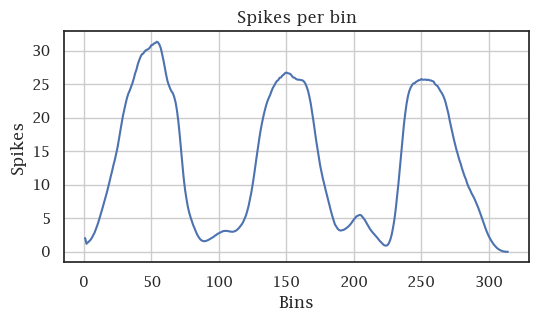

In [31]:
# Step 1: Read CSV
df = pd.read_csv("spikes.csv")

# Step 2: Set font family and size
font = {'family': 'serif', 'serif': ['Lucida Fax'], 'size': 12}
plt.rc('font', **font)

# Step 3: Set figure size
# A4 paper width in inches
A4_WIDTH_INCHES = 6

# Set figure size with width matching A4 paper
plt.figure(figsize=(A4_WIDTH_INCHES, 3))  # You can adjust the height as needed

# Step 4: Plot Data
plt.plot(df["step"], df["value"])
plt.xlabel("Bins")
plt.ylabel("Spikes")
plt.title("Spikes per bin")
plt.grid(True)
plt.show()

Client received: Hello, you! This is the NMNIST server talking!

Shape: torch.Size([32, 2, 32, 32])
Predicted "4 - four" after 1 steps.


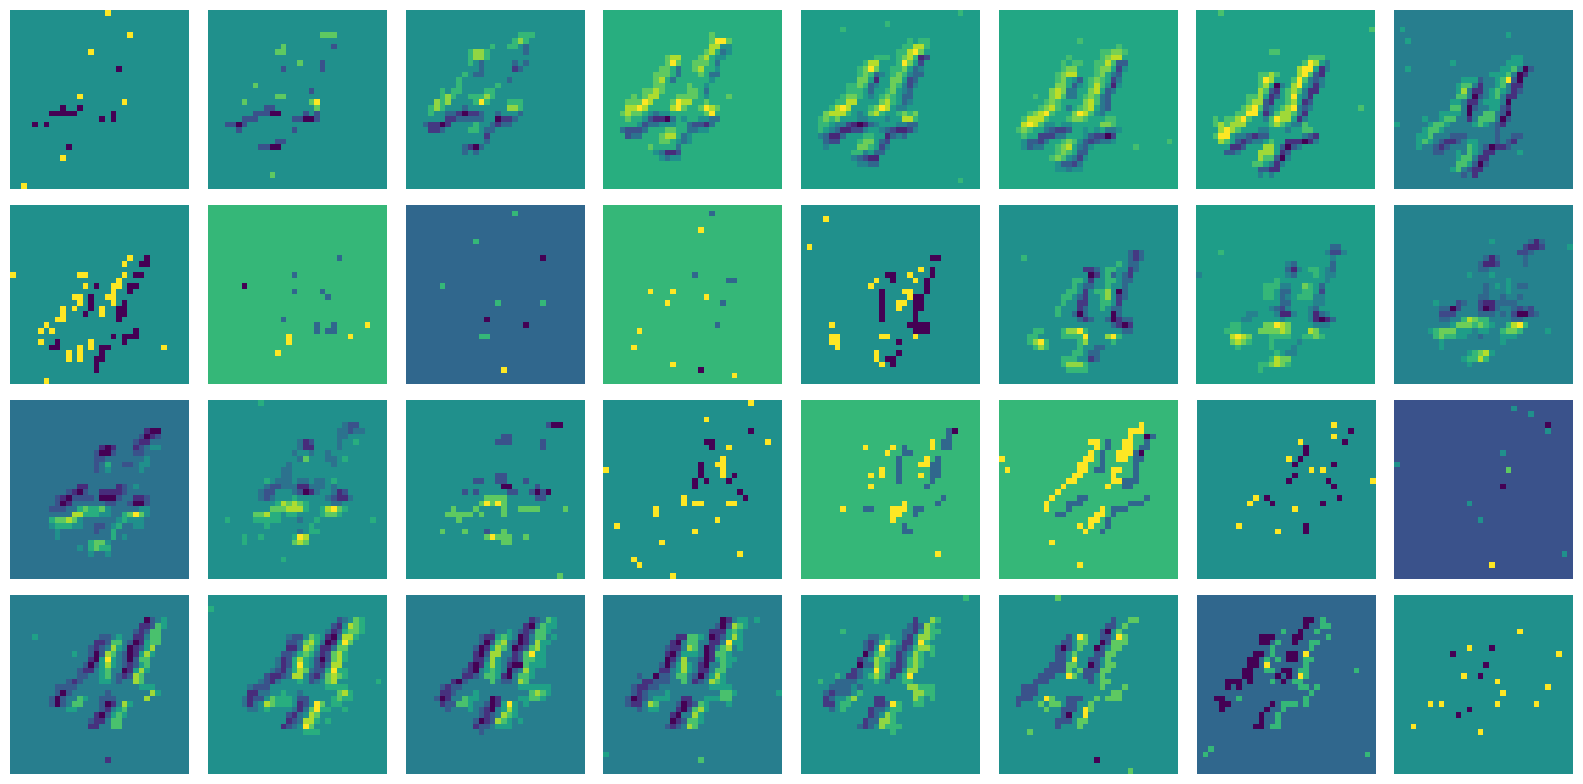

In [141]:
def plot_frames(frames):
    num_frames = len(frames)
    num_rows = num_frames // 8 + (num_frames % 8 > 0)  # Calculate the number of rows
    num_cols = min(num_frames, 8)  # Set the number of columns to 8 or less if there are fewer frames
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 2*num_rows))
    
    # Flatten the axes if there's only one row
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, frame in enumerate(frames):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(frame[1] - frame[0], cmap='viridis')
        axes[row, col].axis("off")
    
    # Remove unused axes
    for i in range(num_frames, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()

label_list = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
              '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

# Fetch data from server
port = 50051
net_client.get_server_name(port)
response_tensor = net_client.get_frame(port)

# Classify response data
prediction, steps = active_model.model.classify(response_tensor)
if isinstance(prediction, int):
    prediction_str = label_list[prediction]
else:
    prediction_str = prediction

# Output
print("")
print(f"Shape: {response_tensor.shape}")
print(f'Predicted "{prediction_str}" after {steps} steps.')
plot_frames(response_tensor)

In [442]:
# Plotting functions
def plot_2d_hist(image_3d, frames=None):
    """ Expect input image_3d in form of (channels, time/frames, y/rows, x/cols)
        Frames variable expects a list of frames to show (no list = all frames)
    """
    channels, depth, height, width = image_3d.shape
    fig, ax = plt.subplots(nrows=1, ncols=channels, figsize=(5*channels, 5))
    ax[0].set_title("On-spikes")
    ax[1].set_title("Off-spikes")
    
    for i in range(channels):
        events = np.array(np.where(image_3d[i]==1.0))
        
        event_depth = np.array(events[0])
        
        if frames:
            mask = np.zeros(event_depth.shape)
            # Add all frame masks together
            for frame in frames:
                mask = np.add(mask, event_depth == frame).astype(bool)
        else:
            mask = np.ones(event_depth.shape).astype(bool)
        
        event_width = np.array(events[2])[mask]
        event_height = np.array(events[1])[mask]
        
        data, x, y = np.histogram2d(event_width, event_height, bins=(32,32), range=([[0, width-1], [0, height-1]]))

        plt.subplot(1, channels, i + 1)
        plt.imshow(data.T)


In [558]:
for events, labels in val_loader_clean:
    output_clean = events.permute(0, 2, 1, 3, 4)
    break

for events, labels in val_loader_noise:
    output_noise = events.permute(0, 2, 1, 3, 4)
    break

torch.Size([2, 32, 32, 32])


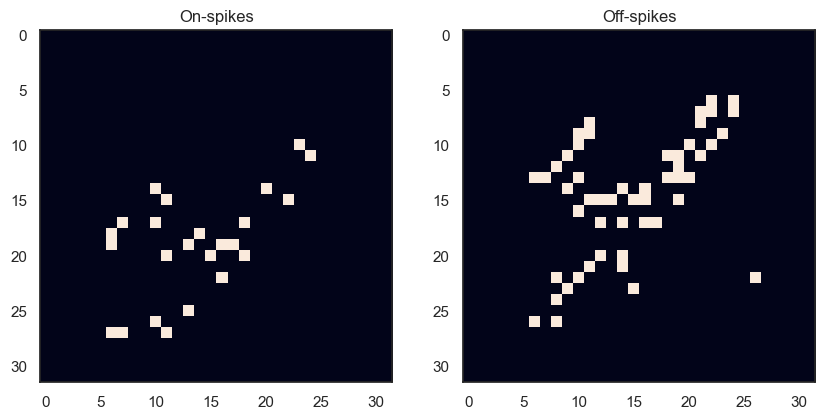

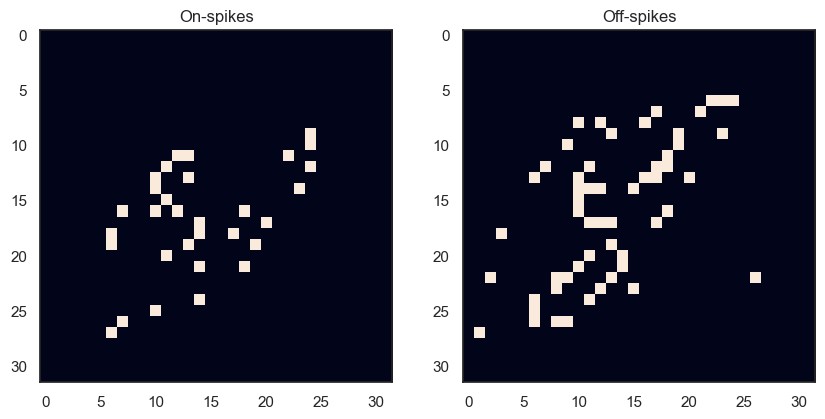

In [566]:
print(output_clean[13].shape)

frame_index = 4
selected_frame_clean = output_clean[13][:, frame_index:frame_index+1, :, :]
selected_frame_noise = output_noise[13][:, frame_index:frame_index+1, :, :]

plot_2d_hist(selected_frame_clean)
plot_2d_hist(selected_frame_noise)